In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

from sklearn.feature_selection import SelectKBest, RFE, SequentialFeatureSelector, RFECV, f_classif, mutual_info_classif
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor

from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

In [177]:
%store -r df_2
%store -r y_train_binary
%store -r X_val_binary
%store -r y_val_binary
%store -r test
%store -r metric_features
%store -r non_metric_features

In [178]:
X_train = df_2
y_train = y_train_binary
X_val = X_val_binary
y_val = y_val_binary
test = test

In [179]:
categorical = X_train.select_dtypes(include=['category','bool','object']).columns
categorical

Index(['is_male', 'has_insurance', 'admission_type', 'medical_specialty',
       'healthy_heartrate', 'discharged_home', 'admission_source',
       'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'metformin', 'insulin',
       'prescribed_diabetes_meds', 'is_inpatient', 'race_AfricanAmerican',
       'race_Caucasian', 'race_Hispanic', 'race_Other'],
      dtype='object')

In [180]:
numerical = X_train.select_dtypes(exclude=['category', 'bool', 'object']).columns
numerical

Index(['age', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'length_of_stay_in_hospital',
       'number_lab_tests', 'non_lab_procedures', 'number_of_medications',
       'number_diagnoses', 'num_medication', 'total_visits_previous_year',
       'total_tests', 'visit_count'],
      dtype='object')

# Encoding Categorical Features

## Frequency Encoding - Medical Specialty 

It is a better approach than one hot encoding since we have a lot of categories, and using it would increase data sparcity. Label encoder wouldn 't be a good approach too since there isn't any hierarchial order in the medical specialty labels. So the best approach in this variable is frequency encoder, specially because we have imbalanced data (some categories have a great difference in frequency in relation to others).

In [181]:
#frequency encoding in X_train
freq_encod_ms = (X_train.groupby('medical_specialty').size()) / len(X_train)
X_train['medical_specialty'] = X_train['medical_specialty'].apply(lambda x : freq_encod_ms[x])

#apply calculated encoding from the X_train in X_val and test dataset
X_val['medical_specialty'] = X_val['medical_specialty'].apply(lambda x : freq_encod_ms[x])
test['medical_specialty'] = test['medical_specialty'].apply(lambda x : freq_encod_ms[x])

# X_train['medical_specialty'] = X_train['medical_specialty'].astype('category')
# X_val['medical_specialty'] = X_val['medical_specialty'].astype('category')
# test['medical_specialty'] = test['medical_specialty'].astype('category')

## Label Encoding - Admission Type
https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2013/04/QAR-commentary-Q1-1617-53636.pdf

Number of patients admitted electively during the quarter. Admissions are split into two 
types, elective and non-elective. Non-elective admissions are emergency admissions an 
elective admissions include all other types.

In [182]:
X_train['admission_type'] = X_train['admission_type'].map({'Emergency': 2, 'Elective': 1, 'Urgent':1})
#X_train['admission_type'] = X_train['admission_type'].astype(int)

X_val['admission_type'] = X_val['admission_type'].map({'Emergency': 2, 'Elective': 1, 'Urgent':1})
#X_val['admission_type'] = X_val['admission_type'].astype(int)

test['admission_type'] = test['admission_type'].map({'Emergency': 2, 'Elective': 1, 'Urgent':1})
#test['admission_type'] = test['admission_type'].astype(int)

## Frequency Encoding - Admission Source

In [183]:
#frequency encoding in X_train
freq_encod_as = (X_train.groupby('admission_source').size()) / len(X_train)
X_train['admission_source'] = X_train['admission_source'].apply(lambda x : freq_encod_as[x])

#apply calculated encoding from the X_train in X_val and test dataset
X_val['admission_source'] = X_val['admission_source'].apply(lambda x : freq_encod_as[x])
test['admission_source'] = test['admission_source'].apply(lambda x : freq_encod_as[x])

# X_train['admission_source'] = X_train['admission_source'].astype('category')
# X_val['admission_source'] = X_val['admission_source'].astype('category')
# test['admission_source'] = test['admission_source'].astype('category')

## Frequency Encoding - Discharge Disposition

we use discharged_home!!

In [184]:
# #frequency encoding in X_train
# freq_encod_as = (X_train.groupby('discharge_disposition').size()) / len(X_train)
# X_train['discharge_disposition'] = X_train['discharge_disposition'].apply(lambda x : freq_encod_as[x])

# #apply calculated encoding from the X_train in X_val and test dataset
# X_val['discharge_disposition'] = X_val['discharge_disposition'].apply(lambda x : freq_encod_as[x])
# test['discharge_disposition'] = test['discharge_disposition'].apply(lambda x : freq_encod_as[x])

# # X_train['discharge_disposition'] = X_train['discharge_disposition'].astype('category')
# # X_val['discharge_disposition'] = X_val['discharge_disposition'].astype('category')
# # test['discharge_disposition'] = test['discharge_disposition'].astype('category')

## Frequency Encoding - A1c test
we use Label/Ordinal Encoder 

In [185]:
# #frequency encoding in X_train
# freq_encod_a1c = (X_train.groupby('a1c_test_result').size()) / len(X_train)
# X_train['a1c_test_result'] = X_train['a1c_test_result'].apply(lambda x : freq_encod_a1c[x])

# #apply calculated encoding from the X_train in X_val and test dataset
# X_val['a1c_test_result'] = X_val['a1c_test_result'].apply(lambda x : freq_encod_a1c[x])
# test['a1c_test_result'] = test['a1c_test_result'].apply(lambda x : freq_encod_a1c[x])

# # X_train['a1c_test_result'] = X_train['a1c_test_result'].astype('category')
# # X_val['a1c_test_result'] = X_val['a1c_test_result'].astype('category')
# # test['a1c_test_result'] = test['a1c_test_result'].astype('category')

In [186]:
#freq_encod_a1c

## Frequency Encoding - Glucose test
we use Label/Ordinal Encoder 

In [187]:
X_train.glucose_test_result.value_counts()

glucose_test_result
0    52234
2     1476
1     1426
Name: count, dtype: int64

In [188]:
# #frequency encoding in X_train
# freq_encod_g = (X_train.groupby('glucose_test_result').size()) / len(X_train)
# X_train['glucose_test_result'] = X_train['glucose_test_result'].apply(lambda x : freq_encod_g[x])

# #apply calculated encoding from the X_train in X_val and test dataset
# X_val['glucose_test_result'] = X_val['glucose_test_result'].apply(lambda x : freq_encod_g[x])
# test['glucose_test_result'] = test['glucose_test_result'].apply(lambda x : freq_encod_g[x])

# # X_train['glucose_test_result'] = X_train['glucose_test_result'].astype('category')
# # X_val['glucose_test_result'] = X_val['glucose_test_result'].astype('category')
# # test['glucose_test_result'] = test['glucose_test_result'].astype('category')

## Frequency Encoding - Primary Diagnosis

In [189]:
#frequency encoding in X_train
freq_encod_pd = (X_train.groupby('primary_diagnosis').size()) / len(X_train)
X_train['primary_diagnosis'] = X_train['primary_diagnosis'].apply(lambda x : freq_encod_pd[x])

#apply calculated encoding from the X_train in X_val and test dataset
X_val['primary_diagnosis'] = X_val['primary_diagnosis'].apply(lambda x : freq_encod_pd[x])
test['primary_diagnosis'] = test['primary_diagnosis'].apply(lambda x : freq_encod_pd[x])

# X_train['primary_diagnosis'] = X_train['primary_diagnosis'].astype('category')
# X_val['primary_diagnosis'] = X_val['primary_diagnosis'].astype('category')
# test['primary_diagnosis'] = test['primary_diagnosis'].astype('category')

## Frequency Encoding - Secondary Diagnosis

In [190]:
#frequency encoding in X_train
freq_encod_sd = (X_train.groupby('secondary_diagnosis').size()) / len(X_train)
X_train['secondary_diagnosis'] = X_train['secondary_diagnosis'].apply(lambda x : freq_encod_sd[x])

#apply calculated encoding from the X_train in X_val and test dataset
X_val['secondary_diagnosis'] = X_val['secondary_diagnosis'].apply(lambda x : freq_encod_sd[x])
test['secondary_diagnosis'] = test['secondary_diagnosis'].apply(lambda x : freq_encod_sd[x])

# X_train['secondary_diagnosis'] = X_train['secondary_diagnosis'].astype('category')
# X_val['secondary_diagnosis'] = X_val['secondary_diagnosis'].astype('category')
# test['secondary_diagnosis'] = test['secondary_diagnosis'].astype('category')


## Frequency Encoding - Additional Diagnosis

In [191]:
#frequency encoding in X_train
freq_encod_ad = (X_train.groupby('additional_diagnosis').size()) / len(X_train)
X_train['additional_diagnosis'] = X_train['additional_diagnosis'].apply(lambda x : freq_encod_ad[x])

#apply calculated encoding from the X_train in X_val and test dataset
X_val['additional_diagnosis'] = X_val['additional_diagnosis'].apply(lambda x : freq_encod_ad[x])
test['additional_diagnosis'] = test['additional_diagnosis'].apply(lambda x : freq_encod_ad[x])

# X_train['additional_diagnosis'] = X_train['additional_diagnosis'].astype('category')
# X_val['additional_diagnosis'] = X_val['additional_diagnosis'].astype('category')
# test['additional_diagnosis'] = test['additional_diagnosis'].astype('category')

## Data Scaling - only on numerical features

### MinMax

In [192]:
# scaler = MinMaxScaler()
# mmdf = scaler.fit_transform(X_train)
# X_train = pd.DataFrame(mmdf, columns = X_train.columns).set_index(X_train.index)
# X_train.head()

In [193]:
# #min max for validation data
# mmdf_val = scaler.fit_transform(X_val)
# X_val = pd.DataFrame(mmdf_val, columns = X_val.columns).set_index(X_val.index)

In [194]:
# #min max for test data
# mmdf_test = scaler.fit_transform(test)
# test = pd.DataFrame(mmdf_test, columns = test.columns).set_index(test.index)

In [195]:
# categorical = [#'is_male', 
#             #    'has_insurance', 
#                'medical_specialty', 
#                'discharged_home', 'admission_source', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis',
#                'glucose_test_result', 'a1c_test_result', 'metformin', 'insulin', 'is_inpatient', 'race_Caucasian', 'race_Other']
#                #,'critical_amount_of_diagnoses', 'critical_amount_of_visits_this_year']

# numerical = X_train.columns.drop(categorical).to_list()

In [196]:
numerical

Index(['age', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'length_of_stay_in_hospital',
       'number_lab_tests', 'non_lab_procedures', 'number_of_medications',
       'number_diagnoses', 'num_medication', 'total_visits_previous_year',
       'total_tests', 'visit_count'],
      dtype='object')

In [197]:
scaler = MinMaxScaler()

X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_val[numerical] = scaler.fit_transform(X_val[numerical])
test[numerical] = scaler.fit_transform(test[numerical])

### Standard

In [198]:
# scaler = StandardScaler()

# X_train[numerical] = scaler.fit_transform(X_train[numerical])
# X_val[numerical] = scaler.fit_transform(X_val[numerical])
# test[numerical] = scaler.fit_transform(test[numerical])

# Balance Data - *Before*

## Oversampling

### Smote

In [199]:
# smote = SMOTE(random_state=42)

# # Apply SMOTE to generate synthetic samples
# X_train, y_train = smote.fit_resample(X_train, y_train)

### Random Oversampling

In [200]:
# over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42) # The sampling_strategy='auto' option balances the classes
# X_train, y_train = over_sampler.fit_resample(X_train, y_train)

## Undersampling

### Random Undersampling

In [201]:
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42) # The sampling_strategy='auto' option balances the classes
X_train, y_train = under_sampler.fit_resample(X_train, y_train)

# Assessing Relationships between Categorical Variables
## Feature Selection

### Chi2 - Test Independence (Categorical variable x target)

Independence between a single categorical predictor variable and the binary target variable

In [202]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

for var in X_train[categorical]:
    TestIndependence(X_train[categorical][var],y_train.values.ravel(), var) #so that y_train is 1-D

is_male is NOT an important predictor. (Discard is_male from model)
has_insurance is NOT an important predictor. (Discard has_insurance from model)
admission_type is NOT an important predictor. (Discard admission_type from model)
medical_specialty is IMPORTANT for Prediction
healthy_heartrate is NOT an important predictor. (Discard healthy_heartrate from model)
discharged_home is IMPORTANT for Prediction
admission_source is NOT an important predictor. (Discard admission_source from model)
primary_diagnosis is IMPORTANT for Prediction
secondary_diagnosis is IMPORTANT for Prediction
additional_diagnosis is IMPORTANT for Prediction
glucose_test_result is NOT an important predictor. (Discard glucose_test_result from model)
a1c_test_result is IMPORTANT for Prediction
change_in_meds_during_hospitalization is IMPORTANT for Prediction
metformin is IMPORTANT for Prediction
insulin is IMPORTANT for Prediction
prescribed_diabetes_meds is IMPORTANT for Prediction
is_inpatient is IMPORTANT for Pred

### Chi2 - Test Independence (Categorical variable x Categorical variable)

Independence between every categorical variables

In [203]:
def TestIndependenceForAll(cat, alpha=0.05):
    results = {}

    for i in range(len(cat.columns)):
        for j in range(i + 1, len(cat.columns)):
            var1 = cat.columns[i]
            var2 = cat.columns[j]

            # Perform chi-squared test for independence
            contingency_table = pd.crosstab(cat[var1], cat[var2])
            chi2, p, _, _ = stats.chi2_contingency(contingency_table)

            # Record the result
            if p < alpha:
                result = "DEPENDENT"
            else:
                result = "INDEPENDENT"

            results[(var1, var2)] = result

    return results

results = TestIndependenceForAll(X_train[categorical])
for (var1, var2), result in results.items():
    if result == 'DEPENDENT':
        print(f'({var1}, {var2}): {result}')

(is_male, medical_specialty): DEPENDENT
(is_male, discharged_home): DEPENDENT
(is_male, primary_diagnosis): DEPENDENT
(is_male, secondary_diagnosis): DEPENDENT
(is_male, additional_diagnosis): DEPENDENT
(is_male, a1c_test_result): DEPENDENT
(is_male, change_in_meds_during_hospitalization): DEPENDENT
(is_male, prescribed_diabetes_meds): DEPENDENT
(is_male, is_inpatient): DEPENDENT
(is_male, race_AfricanAmerican): DEPENDENT
(is_male, race_Caucasian): DEPENDENT
(is_male, race_Hispanic): DEPENDENT
(has_insurance, admission_type): DEPENDENT
(has_insurance, medical_specialty): DEPENDENT
(has_insurance, discharged_home): DEPENDENT
(has_insurance, primary_diagnosis): DEPENDENT
(has_insurance, secondary_diagnosis): DEPENDENT
(has_insurance, additional_diagnosis): DEPENDENT
(has_insurance, glucose_test_result): DEPENDENT
(has_insurance, a1c_test_result): DEPENDENT
(has_insurance, change_in_meds_during_hospitalization): DEPENDENT
(has_insurance, metformin): DEPENDENT
(has_insurance, insulin): DEP

### Cramer's V 

Cramér’s V is an effect size measurement for the chi-square test of independence. It measures how strongly two categorical fields are associated.

If two variables have a high Cramér's V value, it suggests a strong association between them. In some cases, this may indicate redundancy, and you might consider dropping one of the variables to simplify your model. <br>

https://www.ibm.com/docs/en/cognos-analytics/11.1.0?topic=terms-cramrs-v

ES - Effect Size

ES ≤ 0.2	The result is weak. Although the result is statistically significant, the fields are only weakly associated. <br>
0.2 < ES ≤ 0.6	The result is moderate. The fields are moderately associated. <br>
ES > 0.6	The result is strong. The fields are strongly associated. <br>

#### ES <= 0.2

In [204]:
# Function to calculate Cramér's V for categorical variable pairs
def calculate_cramers_v_pair(cat_var1, cat_var2):
    contingency_table = pd.crosstab(X_train[cat_var1], X_train[cat_var2])
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Calculate Cramér's V for each pair of categorical variables
# for i in range(len(categorical)):
#     for j in range(i+1, len(categorical)):
#         cat_var1 = categorical[i]
#         cat_var2 = categorical[j]
        
#         v = round(calculate_cramers_v_pair(cat_var1, cat_var2), 5)
#         if v <= 0.2:  # threshold
#             print(f"Cramér's V between {cat_var1} and {cat_var2}: {v}")

#### 0.2 < ES <= 0.6

In [205]:
for i in range(len(categorical)):
    for j in range(i+1, len(categorical)):
        cat_var1 = categorical[i]
        cat_var2 = categorical[j]
        
        v = round(calculate_cramers_v_pair(cat_var1, cat_var2), 5)
        if v > 0.2 and v <= 0.6:  # threshold
            print(f"Cramér's V between {cat_var1} and {cat_var2}: {v}")

Cramér's V between has_insurance and medical_specialty: 0.25018
Cramér's V between admission_type and medical_specialty: 0.39951
Cramér's V between admission_type and primary_diagnosis: 0.25296
Cramér's V between medical_specialty and admission_source: 0.24926


Cramér's V between admission_source and primary_diagnosis: 0.21663
Cramér's V between change_in_meds_during_hospitalization and metformin: 0.29738
Cramér's V between change_in_meds_during_hospitalization and insulin: 0.51953
Cramér's V between change_in_meds_during_hospitalization and prescribed_diabetes_meds: 0.49216
Cramér's V between metformin and prescribed_diabetes_meds: 0.25204
Cramér's V between insulin and prescribed_diabetes_meds: 0.57804
Cramér's V between race_Caucasian and race_Hispanic: 0.24458
Cramér's V between race_Caucasian and race_Other: 0.39596


#### ES > 0.6

In [206]:
for i in range(len(categorical)):
    for j in range(i+1, len(categorical)):
        cat_var1 = categorical[i]
        cat_var2 = categorical[j]
        
        v = round(calculate_cramers_v_pair(cat_var1, cat_var2), 5)
        if v > 0.6:  # threshold
            print(f"Cramér's V between {cat_var1} and {cat_var2}: {v}")

Cramér's V between admission_type and admission_source: 0.69404
Cramér's V between race_AfricanAmerican and race_Caucasian: 0.78945


------------------------------------
admission_type and admission_source: 0.51844 <br>
change_in_meds_during_hospitalization and insulin: 0.51419<br>
change_in_meds_during_hospitalization and prescribed_diabetes_meds: 0.50545<br>
insulin and prescribed_diabetes_meds: 0.58486<br>
race_AfricanAmerican and race_Caucasian: 0.76722

drop: admission_type, change_in_meds_during_hospitalization, prescribed_diabetes_meds, race_AfricanAmerican<br>

------------------------------------


### ANOVA (Analysis of Variance) -> Categorical x Numerical

In [207]:
# df = pd.concat([X_train, y_train], axis=1)

# # Perform ANOVA for each numerical variable with respect to the categorical variables
# anova_results = []

# for num_var in numerical:
#     for cat_var in categorical:
#         formula = f"{num_var} ~ C({cat_var})"
#         model = ols(formula, data=df).fit()
#         anova_table = sm.stats.anova_lm(model, typ=2)
#         anova_results.append({
#             'Numerical Variable': num_var,
#             'Categorical Variable': cat_var,
#             'F-Statistic': anova_table['F'][0],
#             'P-Value': anova_table['PR(>F)'][0]
#         })

# anova_df = pd.DataFrame(anova_results)
# anova_df

In [208]:
# # groups with significant differences 
# # H0​: there are no significant differences among the group means (it states that all population group means are equal)
# filtered_results = anova_df[(anova_df['F-Statistic'] > 10) & (anova_df['P-Value'] < 0.05)]
# filtered_results


In [209]:
def drop_features(df):

    df.drop('is_male', axis = 1, inplace=True)
    df.drop('admission_type', axis = 1, inplace=True) #
    df.drop('healthy_heartrate', axis = 1, inplace=True)
    df.drop('race_AfricanAmerican', axis = 1, inplace=True) #
    df.drop('race_Hispanic', axis = 1, inplace=True) 
    df.drop('prescribed_diabetes_meds', axis = 1, inplace=True) #
    df.drop('change_in_meds_during_hospitalization', axis = 1, inplace=True) #

drop_features(X_train)
drop_features(X_val)
drop_features(test)

# Assessing Relationships between Numerical Variable x Numerical Variable
## Feature Selection  - Filter Methods

Check if any of the numerical variables is univariate (variance is equal to 0). Drop those variables if existent.

In [210]:
X_train.var()

age                                   0.029665
has_insurance                         0.240578
outpatient_visits_in_previous_year    0.014054
emergency_visits_in_previous_year     0.011303
inpatient_visits_in_previous_year     0.036012
medical_specialty                     0.077451
discharged_home                       0.197621
admission_source                      0.034618
length_of_stay_in_hospital            0.060158
number_lab_tests                      0.043739
non_lab_procedures                     0.07472
number_of_medications                 0.016584
primary_diagnosis                     0.011898
secondary_diagnosis                   0.013166
additional_diagnosis                  0.010885
number_diagnoses                      0.028163
glucose_test_result                   0.140539
a1c_test_result                       0.424167
num_medication                        0.022071
metformin                             0.153679
insulin                               0.247379
total_visits_

### Pearson Correlation

https://www.analyticsvidhya.com/blog/2021/03/comparison-of-pearson-and-spearman-correlation-coefficients/

para explicar

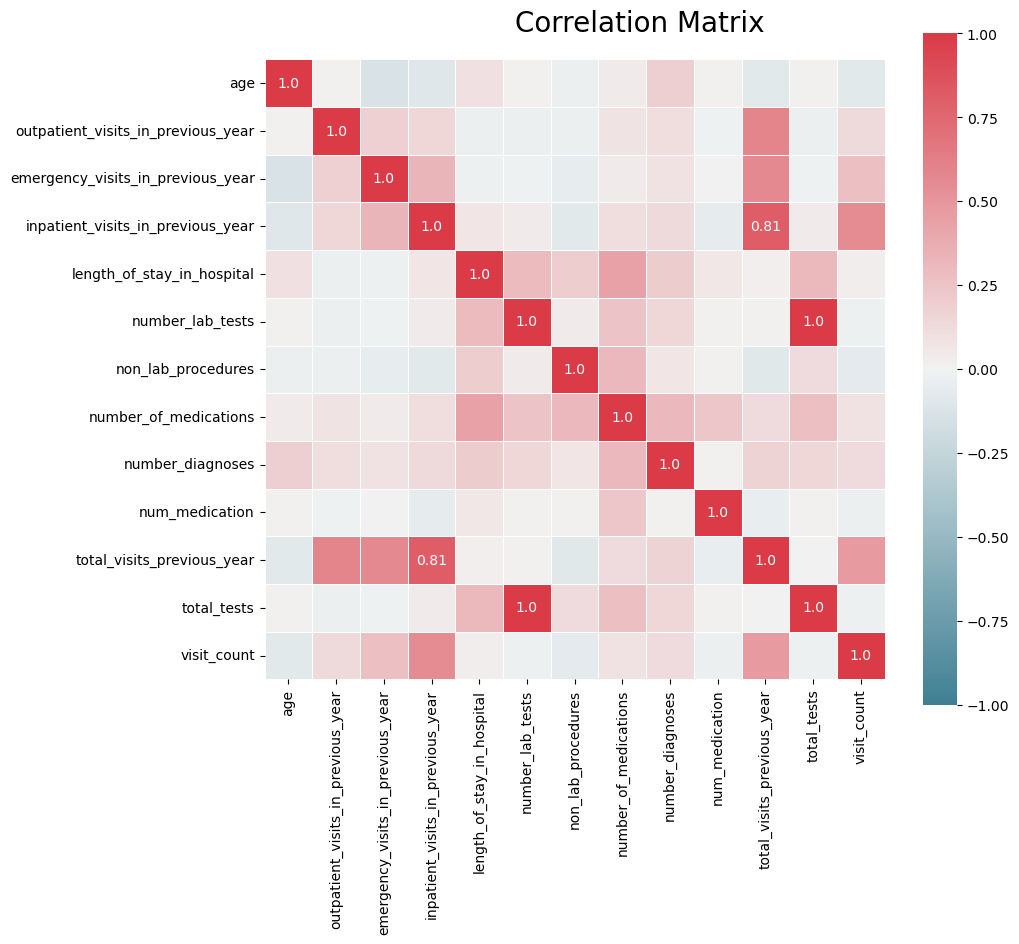

In [211]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(X_train[numerical].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.65
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix", fontsize=20)

plt.show()

In [212]:
# Calculate the correlation matrix
correlation_matrix = X_train.corr()

# Find pairs of variables with a correlation greater than 0.65
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.65:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))
# Display the pairs of variables with high correlation
for pair in high_correlation_pairs:
    correlation_value = correlation_matrix.loc[pair[0], pair[1]]
    print(f"High Correlation: {pair[0]} and {pair[1]} - Correlation: {correlation_value}")


High Correlation: inpatient_visits_in_previous_year and total_visits_previous_year - Correlation: 0.8123692611944647
High Correlation: number_lab_tests and total_tests - Correlation: 0.9964935093145459


### Spearman Correlation

In [213]:
# Calculate the correlation matrix
correlation_matrix = X_train.corr(method='spearman')

# Find pairs of variables with a correlation greater than 0.65
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.65:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))
# Display the pairs of variables with high correlation
for pair in high_correlation_pairs:
    correlation_value = correlation_matrix.loc[pair[0], pair[1]]
    print(f"High Correlation: {pair[0]} and {pair[1]} - Correlation: {correlation_value}")


High Correlation: inpatient_visits_in_previous_year and total_visits_previous_year - Correlation: 0.8184886853883835
High Correlation: number_lab_tests and total_tests - Correlation: 0.9958105255224255


These variables will be considered as non correlatated to the target and so they are going to be dropped.

Crossing the outputs of the above methods we will drop the following columns: total_visits_previous_year,total_tests,is_male, admission_type, healthy_heartrate, race_AfricanAmerican,race_Asian,race_Hispanic.

In [214]:
def drop_features(df):
    
    df.drop('total_visits_previous_year', axis = 1, inplace=True)
    df.drop('total_tests', axis = 1, inplace=True)
    # df.drop('num_medication', axis = 1, inplace=True)

drop_features(X_train)
drop_features(X_val)
drop_features(test)

## Wrapper Methods

### Decision Tree 

In [125]:
gini_importance = DecisionTreeClassifier().fit(X_train, y_train).feature_importances_

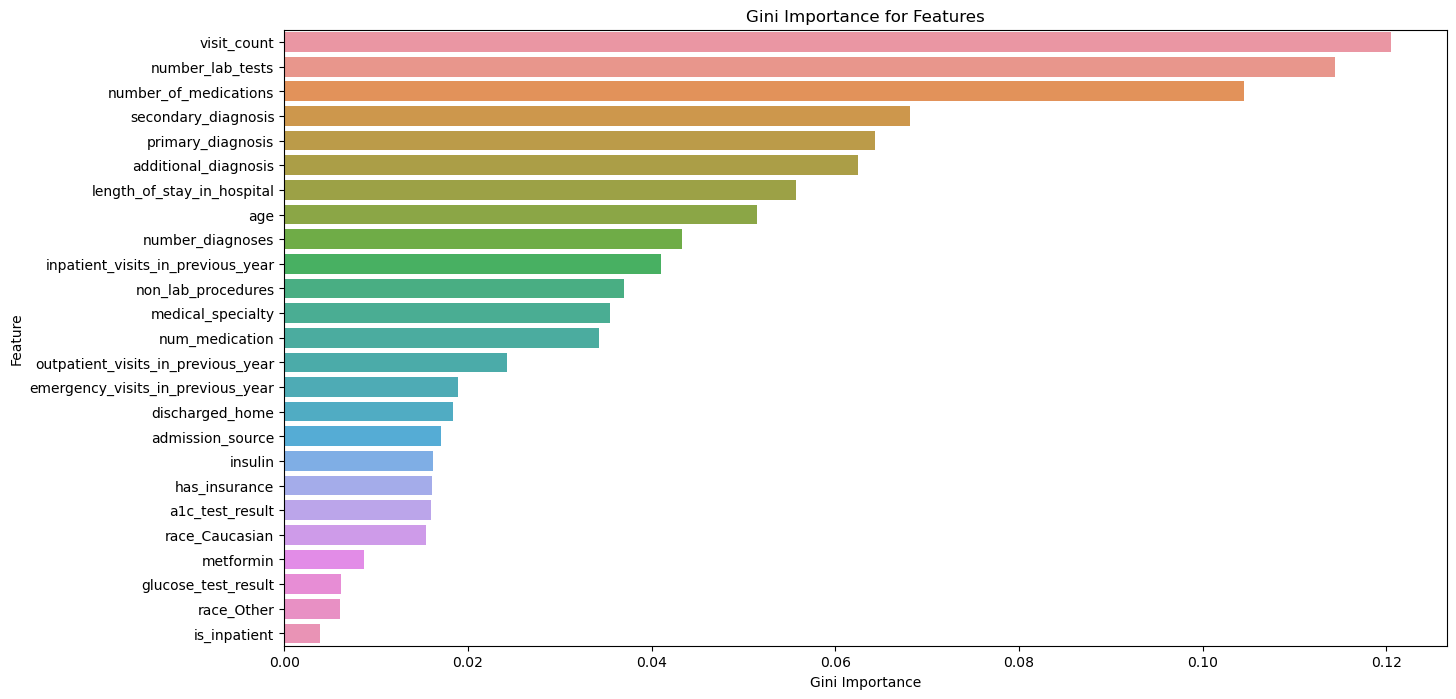

In [189]:
zippy = pd.DataFrame(zip(gini_importance), columns=['gini'])
zippy['col'] = X_train.columns
tidy = zippy.melt(id_vars='col').rename(columns={'col': 'Variable', 'value': 'Value'})

# Sort the DataFrame by Gini importance in descending order
tidy.sort_values(['Value'], ascending=False, inplace=True)

# Plotting using Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(y='Variable', x='Value', data=tidy)
plt.title('Gini Importance for Features')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.show()

https://datascience.stackexchange.com/questions/116549/decision-tree-vs-logistic-regression-feature-importances

Para explicar

### KBest (Mutual Information)

In [205]:
# Assuming X_train is your DataFrame with features and y_train['readmitted_binary'] is the target variable
# You may need to encode categorical variables appropriately before using mutual_info_classif

# List of features (numerical and/or encoded categorical)
features = X_train.columns

# Calculate mutual information for each feature with the target variable
mutual_info_scores = mutual_info_classif(X_train, y_train.values.ravel())

# Create a DataFrame to display the results
mutual_info_df = pd.DataFrame({'Feature': features, 'Mutual_Information': mutual_info_scores})

# Display the results, sorted by mutual information score
mutual_info_df = mutual_info_df.sort_values(by='Mutual_Information', ascending=False)

sel_cols = SelectKBest(mutual_info_classif, k=15)
sel_cols.fit(X_train, y_train.values.ravel())
cols=X_train.columns[sel_cols.get_support()]
cols

Index(['age', 'has_insurance', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'medical_specialty',
       'length_of_stay_in_hospital', 'non_lab_procedures',
       'secondary_diagnosis', 'number_diagnoses', 'glucose_test_result',
       'a1c_test_result', 'num_medication', 'is_inpatient', 'visit_count'],
      dtype='object')

### Gradient Boosting 

In [128]:
# Create a Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Fit the model to the training data
gb_classifier.fit(X_train, y_train.values.ravel())

# Get feature importances
feature_importances = gb_classifier.feature_importances_

# Display feature importances
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

# Select the top-k most important features
k = 7
top_k_features = np.array(X_train.columns)[np.argsort(feature_importances)[::-1][:k]]
print(f"\nTop-{k} features: {top_k_features.tolist()}")

age: 0.012948782719843874
has_insurance: 0.02272193352141866
outpatient_visits_in_previous_year: 0.010652094086261062
emergency_visits_in_previous_year: 0.01002280161148114
inpatient_visits_in_previous_year: 0.1557957738606961
medical_specialty: 0.006791645940302672
discharged_home: 0.061576605389488795
admission_source: 0.0029902564102541516
length_of_stay_in_hospital: 0.019508333785774493
number_lab_tests: 0.016361306768029542
non_lab_procedures: 0.006298254027617831
number_of_medications: 0.014425735187230516
primary_diagnosis: 0.010513480389183255
secondary_diagnosis: 0.012950832402796994
additional_diagnosis: 0.013197380263807087
number_diagnoses: 0.01173967933945588
glucose_test_result: 0.0008718060464818982
a1c_test_result: 0.0032624228834535834
num_medication: 0.01190983111661392
metformin: 0.010975331953452131
insulin: 0.0005819484590834005
is_inpatient: 0.0007083949510268691
race_Caucasian: 0.0025783011056279472
race_Other: 0.0021585507953900463
visit_count: 0.578458516985228

escolhemos as melhores 7 pq tendo em conta a importancia das features é o que faz mais sentido

### Sequential Forward Selection - Random Forest (with Cross Validation)

In [129]:
X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])

X_array = X.to_numpy()
y_array = y.values.ravel()

clf = RandomForestClassifier(n_estimators=100, random_state=42)

sfs = SequentialFeatureSelector(
    clf,
    n_features_to_select=11,
    direction='forward',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
)

sfs.fit(X_array, y_array)

selected_features = X_train.columns[sfs.support_]

# Print the selected features
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['has_insurance', 'inpatient_visits_in_previous_year',
       'medical_specialty', 'discharged_home', 'glucose_test_result',
       'num_medication', 'metformin', 'insulin', 'race_Caucasian',
       'race_Other', 'visit_count'],
      dtype='object')


AttributeError: 'SequentialFeatureSelector' object has no attribute 'best_score_'

### Sequential Backward Selection - Random Forest (with Cross Validation)

In [130]:
X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])

X_array = X.to_numpy()
y_array = y.values.ravel()  # ravel(): Return a contiguous flattened array; Ensure that it's a 1D array

# Create a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a SequentialFeatureSelector with cross-validation
sfs = SequentialFeatureSelector(
    clf,
    n_features_to_select=15,  # Specify the number of features to select
    direction='backward',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # Specify the cross-validation strategy
    scoring='f1',  # Choose an appropriate scoring metric
)

# Fit the SequentialFeatureSelector on the training data
sfs.fit(X_array, y_array)

# Get the selected features and their indices
selected_features = X_train.columns[sfs.support_]
selected_indices = sfs.support_

# Print the selected features
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'medical_specialty',
       'discharged_home', 'length_of_stay_in_hospital', 'number_lab_tests',
       'number_of_medications', 'primary_diagnosis', 'secondary_diagnosis',
       'additional_diagnosis', 'number_diagnoses', 'a1c_test_result',
       'num_medication', 'visit_count'],
      dtype='object')


### Recursive Feature Elimination -  Logistic Regression

In [204]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

nof_list = np.arange(2, 20)            
high_f1_score = 0
optimal_nof = 0           
train_f1_score_list = []
val_f1_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression()
    
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_val_rfe = rfe.transform(X_val)
    model.fit(X_train_rfe, y_train)
    
    # Store results on training data
    train_predictions = model.predict(X_train_rfe)
    train_f1_score = f1_score(y_train, train_predictions)
    train_f1_score_list.append(train_f1_score)
    
    # Store results on validation data
    val_predictions = model.predict(X_val_rfe)
    val_f1_score = f1_score(y_val, val_predictions)
    val_f1_score_list.append(val_f1_score)
    
    # Check best F1 score
    if val_f1_score >= high_f1_score:
        high_f1_score = val_f1_score
        optimal_nof = nof_list[n]
        features_to_select = pd.Series(rfe.support_, index=X_train.columns)

print("Optimal number of features: %d" % optimal_nof)
print("F1 score with %d features: %f" % (optimal_nof, high_f1_score))
print(f"Features to select:\n{features_to_select}")


Optimal number of features: 14
F1 score with 14 features: 0.272580
Features to select:
age                                    True
has_insurance                          True
outpatient_visits_in_previous_year    False
emergency_visits_in_previous_year      True
inpatient_visits_in_previous_year      True
medical_specialty                     False
discharged_home                        True
admission_source                       True
length_of_stay_in_hospital            False
number_lab_tests                       True
non_lab_procedures                    False
number_of_medications                  True
primary_diagnosis                     False
secondary_diagnosis                   False
additional_diagnosis                   True
number_diagnoses                       True
glucose_test_result                   False
a1c_test_result                       False
num_medication                         True
metformin                              True
insulin                          

### Recursive Feature Elimination -  Logistic Regression (with Cross Validation)

This implementation uses cross-validation during model training AND automatically finds the optimal number of features.

In [132]:
# logr = LogisticRegression()
# cv = StratifiedKFold(8)

# X = pd.concat([X_train, X_val])
# y = pd.concat([y_train, y_val])

# X_array = X.to_numpy()
# y_array = y.values.ravel()

# rfecv = RFECV(
#     estimator=logr,
#     step=1,  # how many features are removed at each iteration
#     cv=cv,
#     scoring="f1",
#     min_features_to_select=3,
#     n_jobs=2,
# )
# rfecv.fit(X_array, y_array)

# print(f"Optimal number of features: {rfecv.n_features_}")

# # Print F1 scores for each feature subset
# print("F1 scores for each feature subset:")
# print(rfecv.cv_results_['mean_test_score'])

# # Print selected features
# selected_features = np.array(X_train.columns)[rfecv.support_]
# print("Selected features:", selected_features.tolist())

Optimal number of features: 24
F1 scores for each feature subset:
[0.39734236 0.40429985 0.40571632 0.40179536 0.40937261 0.41319168
 0.41441643 0.41640318 0.41575403 0.41549505 0.4154092  0.41778085
 0.41648757 0.41673486 0.41621429 0.41910826 0.41896019 0.4188773
 0.41868708 0.41873653 0.4194275  0.41951776 0.41950333]
Selected features: ['age', 'has_insurance', 'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'medical_specialty', 'discharged_home', 'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'primary_diagnosis', 'additional_diagnosis', 'number_diagnoses', 'glucose_test_result', 'a1c_test_result', 'num_medication', 'metformin', 'insulin', 'is_inpatient', 'race_Caucasian', 'race_Other', 'visit_count']


# Model Analysis


In [215]:
X_train_select = X_train.copy()
X_val_select = X_val.copy()
test_select = test.copy()

In [216]:
selected_features = ['visit_count', 'number_lab_tests', 'number_of_medications', 
                    'length_of_stay_in_hospital', 'inpatient_visits_in_previous_year',
                    'number_diagnoses', 'medical_specialty', 'num_medication',
                    'discharged_home', 'has_insurance', 'emergency_visits_in_previous_year'
                     ]

X_train_select=X_train_select[selected_features]
X_val_select=X_val_select[selected_features]
test_select=test_select[selected_features]

## Logistic Regression

The confusion matrix in sklearn is presented in the following format: <br>
[ [ TN  FP  ] <br>
    [ FN  TP ] ]

In [623]:
log_model = LogisticRegression(random_state=42)
lm=log_model.fit(X_train_select, y_train)

y_pred = lm.predict(X_val_select)

cm = confusion_matrix(y_val, y_pred)
print(cm, '\n')

f1 = round(f1_score(y_val, y_pred), 4)
print(f'F1 score: {f1}')

[[10846  1812]
 [ 1056   534]] 

F1 score: 0.2713


## SVM

In [624]:
svm_model = SVC(random_state=42)

svm=svm_model.fit(X_train_select, y_train)

y_pred = svm_model.predict(X_val_select)

f1 = round(f1_score(y_val,y_pred), 4)
print(f'F1 Score: {f1}')

F1 Score: 0.2897


## Neural Networks

In [196]:
clf = MLPClassifier(random_state=42)

nn=clf.fit(X_train_select, y_train)

y_pred = nn.predict(X_val_select)

f1 = round(f1_score(y_val,y_pred), 4)
print(f'F1 Score: {f1}')

F1 Score: 0.2907


## Decision Trees

In [626]:
clf_model = DecisionTreeClassifier(random_state=42)

clf=clf_model.fit(X_train_select, y_train)

y_pred = clf.predict(X_val_select)

f1 = round(f1_score(y_val, y_pred), 4)
print(f"F1 Score: {f1}")

F1 Score: 0.2175


# Embedded 

## Boosting

### Gradient Boosting

In [627]:
gb = GradientBoostingClassifier(random_state=42)

gbc = gb.fit(X_train_select, y_train)

y_pred = gbc.predict(X_val_select)


f1 = round(f1_score(y_val, y_pred), 4)
print(f"F1 Score: {f1}")

F1 Score: 0.2887


### Bagging  (Decision Trees)

In [578]:
bagging = BaggingClassifier(random_state=42)

#bagging = BaggingClassifier(random_state=30, bootstrap=True, n_estimators=150, max_samples=0.1, bootstrap_features=False, oob_score=True)

bagg = bagging.fit(X_train_select, y_train)

y_pred = bagg.predict(X_val_select)

f1 = round(f1_score(y_val, y_pred), 4)
print(f"F1 Score: {f1}")

F1 Score: 0.2443


### Random Forest

In [579]:
rf_model = RandomForestClassifier(random_state=42)

#rf_model = RandomForestClassifier(n_estimators=250, bootstrap=True, max_samples=0.3, max_depth=10, oob_score=True, max_features='sqrt', random_state=49)

rf=rf_model.fit(X_train_select, y_train)

y_pred = rf.predict(X_val_select)

f1 = round(f1_score(y_val,y_pred), 4)
print(f'F1 Score: {f1}')

F1 Score: 0.2678


In [580]:
from sklearn.ensemble import VotingClassifier

# Define individual classifiers
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
svm_model = SVC(probability=True, kernel='linear', random_state=42) 
nn_model = MLPClassifier(random_state=42)
logreg_model = LogisticRegression(random_state=42)

voting_classifier = VotingClassifier(
    estimators=[
        ('DecisionTree', dt_model),
        ('RandomForest', rf_model),
        ('GradientBoosting', gb_model),
        ('SVM', svm_model),
        ('NeuralNetwork', nn_model),
        ('LogisticRegression', logreg_model)
    ],
    voting='hard'  # 'hard': majority voting
)

voting_classifier.fit(X_train_select, y_train)

y_pred = voting_classifier.predict(X_val_select)

f1 = f1_score(y_val, y_pred)

print(f"Ensemble Model F1 Score: {f1:.4f}")


Ensemble Model F1 Score: 0.2876


# Optimizing

In [217]:
X_train = X_train_select
X_val = X_val_select
test = test_select

## Logistic Regrssion

In [ ]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  
    'solver': ['lbfgs']
}

In [ ]:
lr = LogisticRegression(random_state=42)
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring='f1', n_jobs=-1, error_score='raise')
grid_search_lr.fit(X_train, y_train)
best_params_lr = grid_search_lr.best_params_

In [ ]:
best_model_lr = LogisticRegression(**best_params_lr, random_state=42)
best_model_lr.fit(X_train, y_train)
y_pred_lr = best_model_lr.predict(X_val)
accuracy_lr = accuracy_score(y_val, y_pred_lr)
f1_lm = f1_score(y_val, y_pred_lr)
print("Logistic Regression - Best Parameters:", best_params_lr)
print("Logistic Regression - Accuracy:", accuracy_lr)
print("Logistic Regression - F1 Score:", f1_lm)

## SVM

In [189]:
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear','rbf']}  

In [190]:
svm = SVC(random_state=42)
grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, cv=5, scoring='f1')
grid_search_svm.fit(X_train, y_train)
best_params_svm = grid_search_svm.best_params_

In [191]:
best_model_svm = SVC(**best_params_svm, random_state=42)
best_model_svm.fit(X_train, y_train)
y_pred_svm = best_model_svm.predict(X_val)
accuracy_svm = accuracy_score(y_val, y_pred_svm)
f1_svm = f1_score(y_val, y_pred_svm)
print("SVM - Best Parameters:", best_params_svm)
print("SVM - Accuracy:", accuracy_svm)
print("Random Forest - F1 Score:", f1_svm)

SVM - Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
SVM - Accuracy: 0.7669146546883773
Random Forest - F1 Score: 0.2905362102114933


## Neural Networks

In [198]:
param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'solver': ['adam', 'lbfgs', 'sgd']
}


In [199]:
nn = MLPClassifier(random_state=42)
grid_search_nn = GridSearchCV(estimator=nn, param_grid=param_grid_nn, cv=5, scoring='f1')
grid_search_nn.fit(X_train, y_train)
best_params_nn = grid_search_nn.best_params_

In [200]:
best_model_nn = MLPClassifier(**best_params_nn, random_state=42)
best_model_nn.fit(X_train, y_train)
y_pred_nn = best_model_nn.predict(X_val)
accuracy_nn = accuracy_score(y_val, y_pred_nn)
f1_nn = f1_score(y_val, y_pred_nn)
print("Neural Network - Best Parameters:", best_params_nn)
print("Neural Network - Accuracy:", accuracy_nn)
print("Random Forest - F1 Score:", f1_nn)

Neural Network - Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Neural Network - Accuracy: 0.7575800112296462
Random Forest - F1 Score: 0.28959276018099545


## Decision Tree - Bagging

In [ ]:
# Define the parameter grid for Decision Tree with Bagging
param_grid_bagging_dt = {
    'n_estimators': [50, 100, 150, 200],
    'max_samples': [0.2,0.4,0.6,0.8,1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}

In [ ]:
base_dt = DecisionTreeClassifier(random_state=42)
bagging_dt = BaggingClassifier(base_estimator=base_dt, random_state=42)
grid_search_bagging_dt = GridSearchCV(estimator=bagging_dt, param_grid=param_grid_bagging_dt, cv=5, scoring='f1', n_jobs=-1)
grid_search_bagging_dt.fit(X_train, y_train)

best_params_bagging_dt = grid_search_bagging_dt.best_params_

/Users/maria/anaconda3/envs/DM2324_1/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/maria/anaconda3/envs/DM2324_1/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/maria/anaconda3/envs/DM2324_1/lib/python3.11/site-packages/sklearn/ensemble/_bagging.py:802: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/maria/anaconda3/envs/DM2324_1/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warni

KeyboardInterrupt: 

In [ ]:
best_model_bagging_dt = BaggingClassifier(**best_params_bagging_dt, random_state=42)

best_model_bagging_dt.fit(X_train, y_train)

y_pred_bagging_dt = best_model_bagging_dt.predict(X_val)

accuracy_bagging_dt = accuracy_score(y_val, y_pred_bagging_dt)

f1_bagging_dt = f1_score(y_val, y_pred_bagging_dt)

print("Decision Tree with Bagging - Best Parameters:", best_params_bagging_dt)
print("Decision Tree with Bagging - Accuracy:", accuracy_bagging_dt)
print("Decision Tree with Bagging - F1 Score:", f1_bagging_dt)

## Random Forest

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_

In [ ]:
best_model_rf = RandomForestClassifier(**best_params_rf, random_state=42)
best_model_rf.fit(X_train, y_train)
y_pred_rf = best_model_rf.predict(X_val)
accuracy_rf = accuracy_score(y_val, y_pred_rf)
f1_rf = f1_score(y_val, y_pred_rf)
print("Random Forest - Best Parameters:", best_params_rf)
print("Random Forest - Accuracy:", accuracy_rf)
print("Random Forest - F1 Score:", f1_rf)

## Gradient Boosting

In [ ]:
param_grid_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:

gb_model = GradientBoostingClassifier(random_state=42)

grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=5, scoring='f1')

grid_search_gb.fit(X_train, y_train)

best_params_gb = grid_search_gb.best_params_

In [ ]:

best_gb_model = GradientBoostingClassifier(**best_params_gb, random_state=42)

best_gb_model.fit(X_train, y_train)

y_pred_gb = best_gb_model.predict(X_val)

accuracy_gb= accuracy_score(y_val, y_pred_gb)

f1_gb = f1_score(y_val, y_pred_gb) 

print("Gradient Boosting - Best Parameters:", best_params_gb)
print("Gradient Boosting - Accuracy:", accuracy_gb)
print("Gradient Boosting - F1 Score:", f1_gb)


Gradient Boosting - Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Gradient Boosting - Accuracy: 0.7586327905670971
Gradient Boosting - F1 Score: 0.29165808444902164


# Best Performance Models

In [511]:
# X = pd.concat([X_train_select, X_val_select])
# y = pd.concat([y_train, y_val])
# # X_train = X_train_select
# # X_val = X_val_select
# test = test_select

## SVM

In [218]:
svm_model = SVC(random_state=42, C= 1, gamma= 1, kernel= 'rbf')

svm=svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_val)

f1 = round(f1_score(y_val,y_pred), 4)
print(f'F1 Score: {f1}')

F1 Score: 0.2905


## Neural Networks

In [219]:
clf = MLPClassifier(random_state=42, activation=  'relu', alpha= 0.01, hidden_layer_sizes= (50,))

nn=clf.fit(X_train, y_train)

y_pred = nn.predict(X_val)

f1 = round(f1_score(y_val,y_pred), 4)
print(f'F1 Score: {f1}')

F1 Score: 0.2896


## Gradient Boosting

In [220]:
gb = GradientBoostingClassifier(random_state=42, learning_rate= 0.2, max_depth= 3, min_samples_leaf= 2, min_samples_split= 10, n_estimators= 50)

gbc = gb.fit(X_train, y_train)

y_pred = gbc.predict(X_val)

f1 = round(f1_score(y_val, y_pred), 4)
print(f"F1 Score: {f1}")
print('\n')
cm = confusion_matrix(y_val, y_pred)
print(cm)


F1 Score: 0.2917


[[10101  2557]
 [  882   708]]


## Personalized Bagging

In [221]:
from sklearn.ensemble import VotingClassifier

# Define individual classifiers
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42, learning_rate= 0.2, max_depth= 3, min_samples_leaf= 2, min_samples_split= 10, n_estimators= 50)
svm_model = SVC(probability=True, random_state=42, C= 1, gamma= 1, kernel= 'rbf') 
nn_model = MLPClassifier(random_state=42)
logreg_model = LogisticRegression(random_state=42)

voting_classifier = VotingClassifier(
    estimators=[
        ('DecisionTree', dt_model),
        ('RandomForest', rf_model),
        ('GradientBoosting', gb_model),
        ('SVM', svm_model),
        ('NeuralNetwork', nn_model),
        ('LogisticRegression', logreg_model)
    ],
    voting='hard'  # 'hard': majority voting
)

voting_classifier.fit(X_train_select, y_train)

y_pred = voting_classifier.predict(X_val_select)

f1 = f1_score(y_val, y_pred)

print(f"Ensemble Model F1 Score: {f1:.4f}")

print('\n')
cm = confusion_matrix(y_val, y_pred)
print(cm, '\n')

Ensemble Model F1 Score: 0.2950


[[10439  2219]
 [  931   659]] 



----------------------------------

## Predicting the test csv

In [512]:
#y_pred_test_lm=lm.predict(test)
#y_pred_test_rf=rf.predict(test)
y_pred_test_svm=svm.predict(test)
#y_pred_test_nn=nn.predict(test)
#y_pred_test_gnb=gnb.predict(test)
#y_pred_test_dt=clf.predict(test)
# y_pred_test_gbc=gbc.predict(test)

In [513]:
# #Logistic Previsions
# y_pred_test_lm=y_pred_test_lm.tolist()
# y_pred_test_lm = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in y_pred_test_lm]

# #Random Forest Previsions
# y_pred_test_rf=y_pred_test_rf.tolist()
# y_pred_test_rf = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in y_pred_test_rf]

#SVM Predictions
y_pred_test_svm=y_pred_test_svm.tolist()
y_pred_test_svm = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in y_pred_test_svm]

# #Neural networks Predictions
# y_pred_test_nn=y_pred_test_nn.tolist()
# y_pred_test_nn = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in y_pred_test_nn]

# #Gaussian Predictions
# y_pred_test_gnb=y_pred_test_gnb.tolist()
# y_pred_test_gnb = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in y_pred_test_gnb]

# #Decision Trees Predictions
# y_pred_test_dt=y_pred_test_dt.tolist()
# y_pred_test_dt = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in y_pred_test_gnb]

# #Gradient Boosting
# y_pred_test_gbc = y_pred_test_gbc.tolist()
# y_pred_test_gbc = ['No' if x == 0.0 else 'Yes' if x == 1.0 else x for x in y_pred_test_gbc]

In [514]:
file_path = '../project_data/sample_submission.csv' 

submit = pd.read_csv(file_path,index_col = 'encounter_id')

#submit['readmitted_binary']=y_pred_test_lm
#submit['readmitted_binary']=y_pred_test_rf
submit['readmitted_binary']=y_pred_test_svm
#submit['readmitted_binary']=y_pred_test_nn
#submit['readmitted_binary']=y_pred_test_gnb
#submit['readmitted_binary']=y_pred_test_dt
# submit['readmitted_binary']=y_pred_test_gbc

#submit.to_csv('sample_submission_lmrfe.csv', index='encounter_id')
#submit.to_csv('sample_submission_rf2.csv', index='encounter_id')
submit.to_csv('sample_submission_svm2.csv', index='encounter_id')
#submit.to_csv('sample_submission_nn2.csv', index='encounter_id')
#submit.to_csv('sample_submission_gnb2.csv', index='encounter_id')
#submit.to_csv('sample_submission_dt.csv', index='encounter_id')
# submit.to_csv('sample_submission_gbc.csv', index='encounter_id')

-----------------------------------------